### Affichage des classes

In [16]:
import os

# Chemin du dataset d'entraînement
train_path = "PVF-10\\PVF_10_110x60\\train"

# Afficher quelques images
classes = sorted(os.listdir(train_path))  # Liste des classes
print("Classes :", *classes, sep="\n")

Classes :
01bottom dirt
02break
03Debris cover
04junction box heat
05hot cell
06shadow
07short circuit panel
08string short circuit
09substring open circuit
10healthy panel


### Affichage d'images

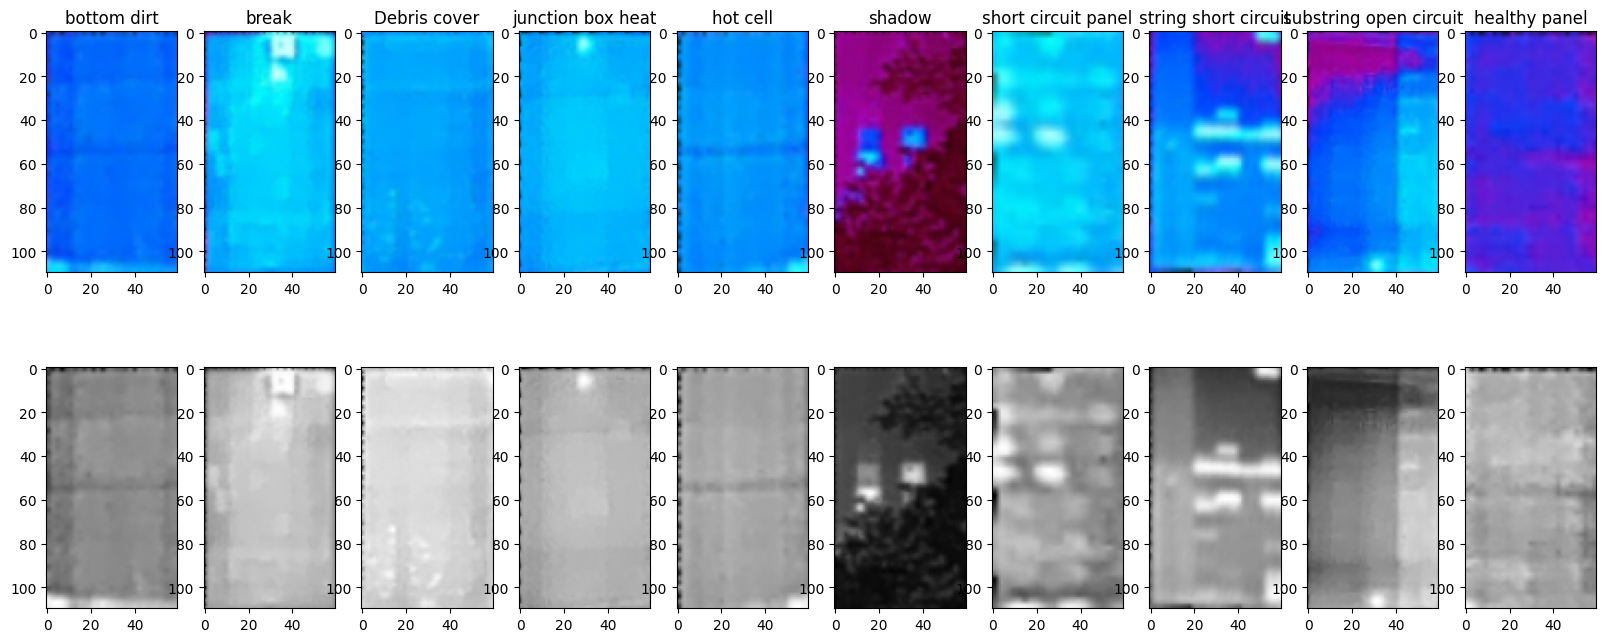

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Affichage d'une image par classe
nums_image = np.random.randint(50, size=len(classes))
fig, ax = plt.subplots(2, len(classes), figsize=(20, 8))
idx_ax= 0
for cls in classes:
    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[nums_image[idx_ax]])
    img = cv2.imread(img_path) 
    ax[0,idx_ax].imshow(img)
    ax[0,idx_ax].set_title(cls[2:])
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Lecture en niveaux de gris
    ax[1,idx_ax].imshow(img_gray, cmap='gray')
    idx_ax+=1

plt.show()

### Chargement des datasets

In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Transformation des images (redimensionnement, normalisation)
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Certaines archis exigent 3 canaux
#     transforms.Resize((224, 224)),  # Taille adaptée à ResNet
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Charger les datasets d'entraînement et de test
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

test_path = "PVF-10\\PVF_10_110x60\\test"
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Chargement par batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Entraînement ResNet18

In [31]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Utiliser CUDA si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger un modèle pré-entraîné (ex : ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # Adapter au nombre de classes
model = model.to(device)

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialisation des listes pour stocker la perte et la précision
train_losses = []
test_losses = []
test_accuracies = []

# Entraînement sur plusieurs époques
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Boucle d'entraînement
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Moyenne de la perte sur dataset d'entraînement
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Évaluation sur dataset de test (sans backprop)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradient
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calcul de la précision
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    # Moyenne de la perte et précision sur dataset de test
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.9384, Test Loss: 0.9687, Test Accuracy: 72.02%
Epoch 2/10, Train Loss: 0.5829, Test Loss: 0.5375, Test Accuracy: 82.67%
Epoch 3/10, Train Loss: 0.5054, Test Loss: 0.5034, Test Accuracy: 85.92%
Epoch 4/10, Train Loss: 0.4471, Test Loss: 0.3395, Test Accuracy: 88.81%
Epoch 5/10, Train Loss: 0.4037, Test Loss: 0.3336, Test Accuracy: 88.63%
Epoch 6/10, Train Loss: 0.3682, Test Loss: 0.3517, Test Accuracy: 90.07%
Epoch 7/10, Train Loss: 0.3629, Test Loss: 0.4153, Test Accuracy: 88.09%
Epoch 8/10, Train Loss: 0.3218, Test Loss: 0.2642, Test Accuracy: 92.96%
Epoch 9/10, Train Loss: 0.2994, Test Loss: 0.3543, Test Accuracy: 88.99%
Epoch 10/10, Train Loss: 0.2875, Test Loss: 0.2920, Test Accuracy: 91.70%


### Evaluation

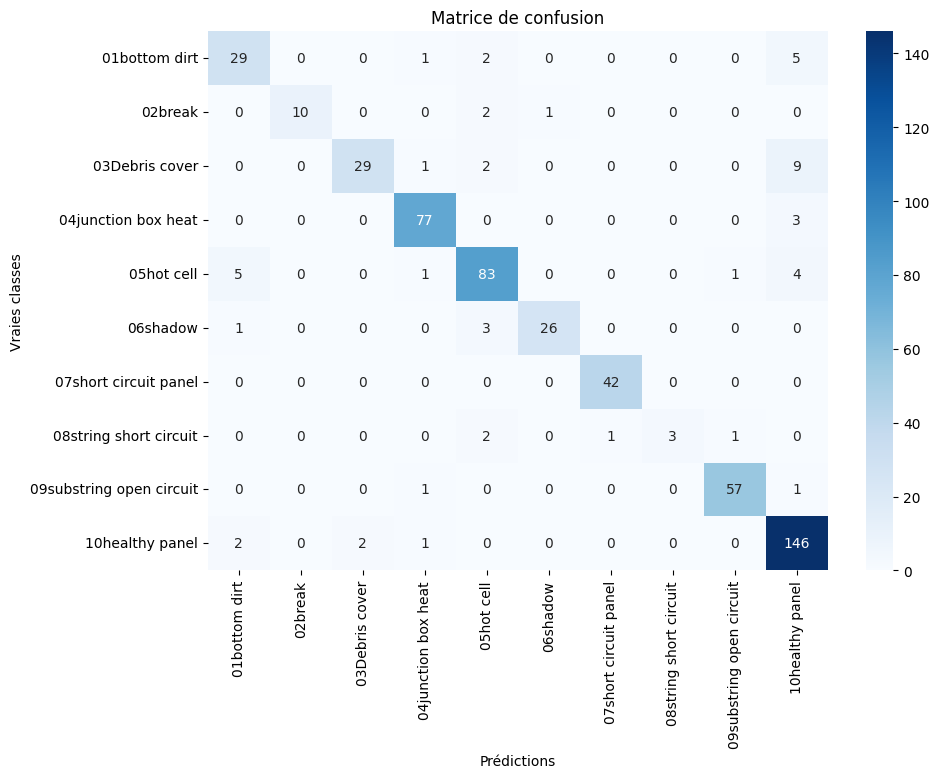

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions sur l'ensemble de test
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [33]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(all_labels, all_preds, target_names=classes)

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                           precision    recall  f1-score   support

           01bottom dirt       0.78      0.78      0.78        37
                 02break       1.00      0.77      0.87        13
          03Debris cover       0.94      0.71      0.81        41
     04junction box heat       0.94      0.96      0.95        80
              05hot cell       0.88      0.88      0.88        94
                06shadow       0.96      0.87      0.91        30
   07short circuit panel       0.98      1.00      0.99        42
  08string short circuit       1.00      0.43      0.60         7
09substring open circuit       0.97      0.97      0.97        59
         10healthy panel       0.87      0.97      0.92       151

                accuracy                           0.91       554
               macro avg       0.93      0.83      0.87       554
            weighted avg       0.91      0.91      0.90       554

